## Project 1: NFL Exploratory Data Analysis
### **Jarrek Holmes**, **Dillan Gajarawala**
#### Dataset: NFL Play-by-Play Data from 2009 to 2018
#### Link: https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016/data#NFL%20Play%20by%20Play%202009-2018%20(v5).csv

## **Question 1: Does "Icing" the kicker actually work?**

## **Question 2: Does an NFL Team need score many points to have many fans?**

## **Question 3: Did the 2013 Denver Broncos deserve to lose the Super Bowl?**

# **Importing Data and Packages**

In [3]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
# from google.colab import drive
# drive.mount('/content/gdrive')
warnings.filterwarnings('ignore')

In [10]:
df = pd.read_csv('nfl-data.csv')
df = df.set_index('play_id')
df.head()

FileNotFoundError: [Errno 2] File b'nfl-data.csv' does not exist: b'nfl-data.csv'

In [9]:
fb_df = pd.read_csv('fb-fans.csv')
fb_df.set_index('Team')
fb_df.head()

Team  Fans (Millions)
0  DAL             8.58
1   NE             7.07
2  PIT             6.38
3   GB             5.30
4  DEN             4.25

# **Data Cleaning**

First, we need to clean the data. This has four parts:

**1)** Fix team names <br>
Three teams have moved in the past eight years, the Jacksonville Jaguars, the LA Chargers, and the LA Rams. Their acronyms also changed, so we'll need to update those to avoid having teams with an unreasonably small number of games.

In [ ]:
def fix_names(s):
  ''' 
  Pass in an attribute s
  Returns a function to fix all nfl team acronyms in s to modern equivalent
  '''
  def f(x):
    if x[s] == 'JAC':
      return 'JAX'
    if x[s] == 'SD':
      return 'LAC'
    if x[s] == 'STL':
      return 'LA'
    return x[s]
  return f

df['defteam'] = df.apply(fix_names('defteam'), axis=1)
df['posteam'] = df.apply(fix_names('posteam'), axis=1)

**2)** Remove NaNs <br>
Many rows include NaNs instead of the appropriate 0. For example, the starting score for a team is 0, not NaN. 

In [ ]:
def nan_to_zero(s):
  ''' 
  Pass in an attribute s
  Returns a function to change all rows in s with NaN to zero
  '''
  def f(x):
    if pd.isna(x[s]):
      return 0
    else:
      return x[s]
  return f

df['posteam_score'] = df.apply(nan_to_zero('posteam_score'), axis=1)
df['posteam_score_post'] = df.apply(nan_to_zero('posteam_score_post'), axis=1)
df['defteam_score'] = df.apply(nan_to_zero('defteam_score'), axis=1)
df['defteam_score_post'] = df.apply(nan_to_zero('defteam_score_post'), axis=1)

**3)** Add score differential <br>
We want to know how many points the possesion team (posteam) and defensive team (defteam) score on each play. Since that's not included in the existing data set, we'll add it here.

In [ ]:
def score_change(s):
  ''' 
  Pass in an attribute s
  Returns a function to add a new row that subtracts (s + '_post') from s
  '''
  def f(x):
    return x[s + '_post'] - x[s]
  return f

df['score_dif_posteam'] = df.apply(score_change('posteam_score'), axis=1)
df['score_dif_defteam'] = df.apply(score_change('defteam_score'), axis=1)

**4)** Add the season <br>
We define a season by the year it starts in. The dataset currently has no way to differentiate which season a game was played in, so this splits it up by starting year.

In [ ]:
from datetime import datetime
def season(x):
  d = datetime.strptime(x['game_date'], '%Y-%m-%d')
  if d.month in [7, 8, 9, 10, 11, 12]:
    return d.year
  return d.year - 1

df['season'] = df.apply(season, axis=1)

# **Data Analysis**

## **Question 1)**
### What is the play type distribution over the last 9 years? Before which play are the most timeouts called? Does 'icing' the kicker actually work (calling a timeout just before they kick a field goal)

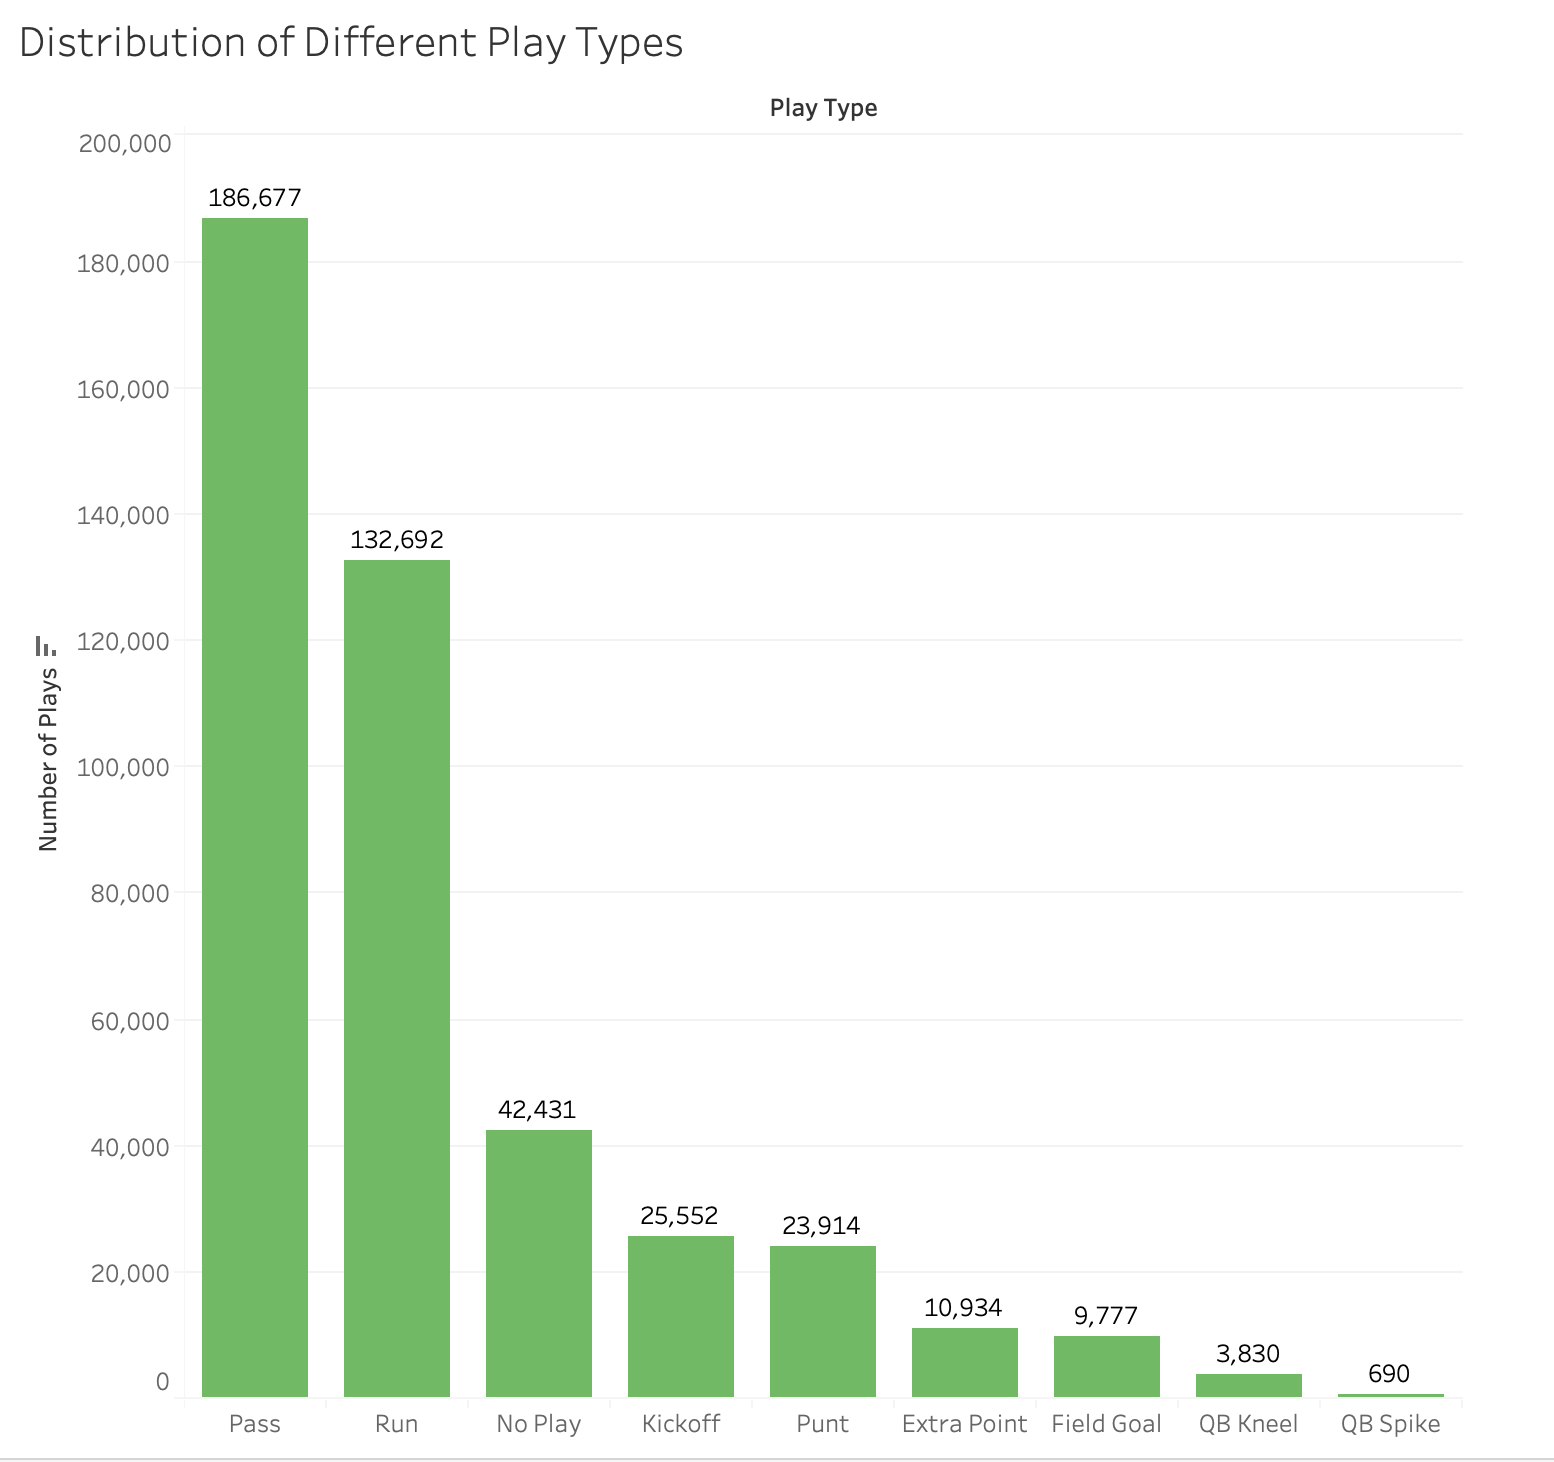

In [3]:
#Number of each type of play
play_type_df = df.play_type.value_counts().plot(kind='bar')
play_type_df.to_csv('exportedForTableau/types_of_plays.csv')
Image(filename='images/PlayTypeDist.png')

<img src='/content/gdrive/My Drive/PlayTypeDist.png'> 

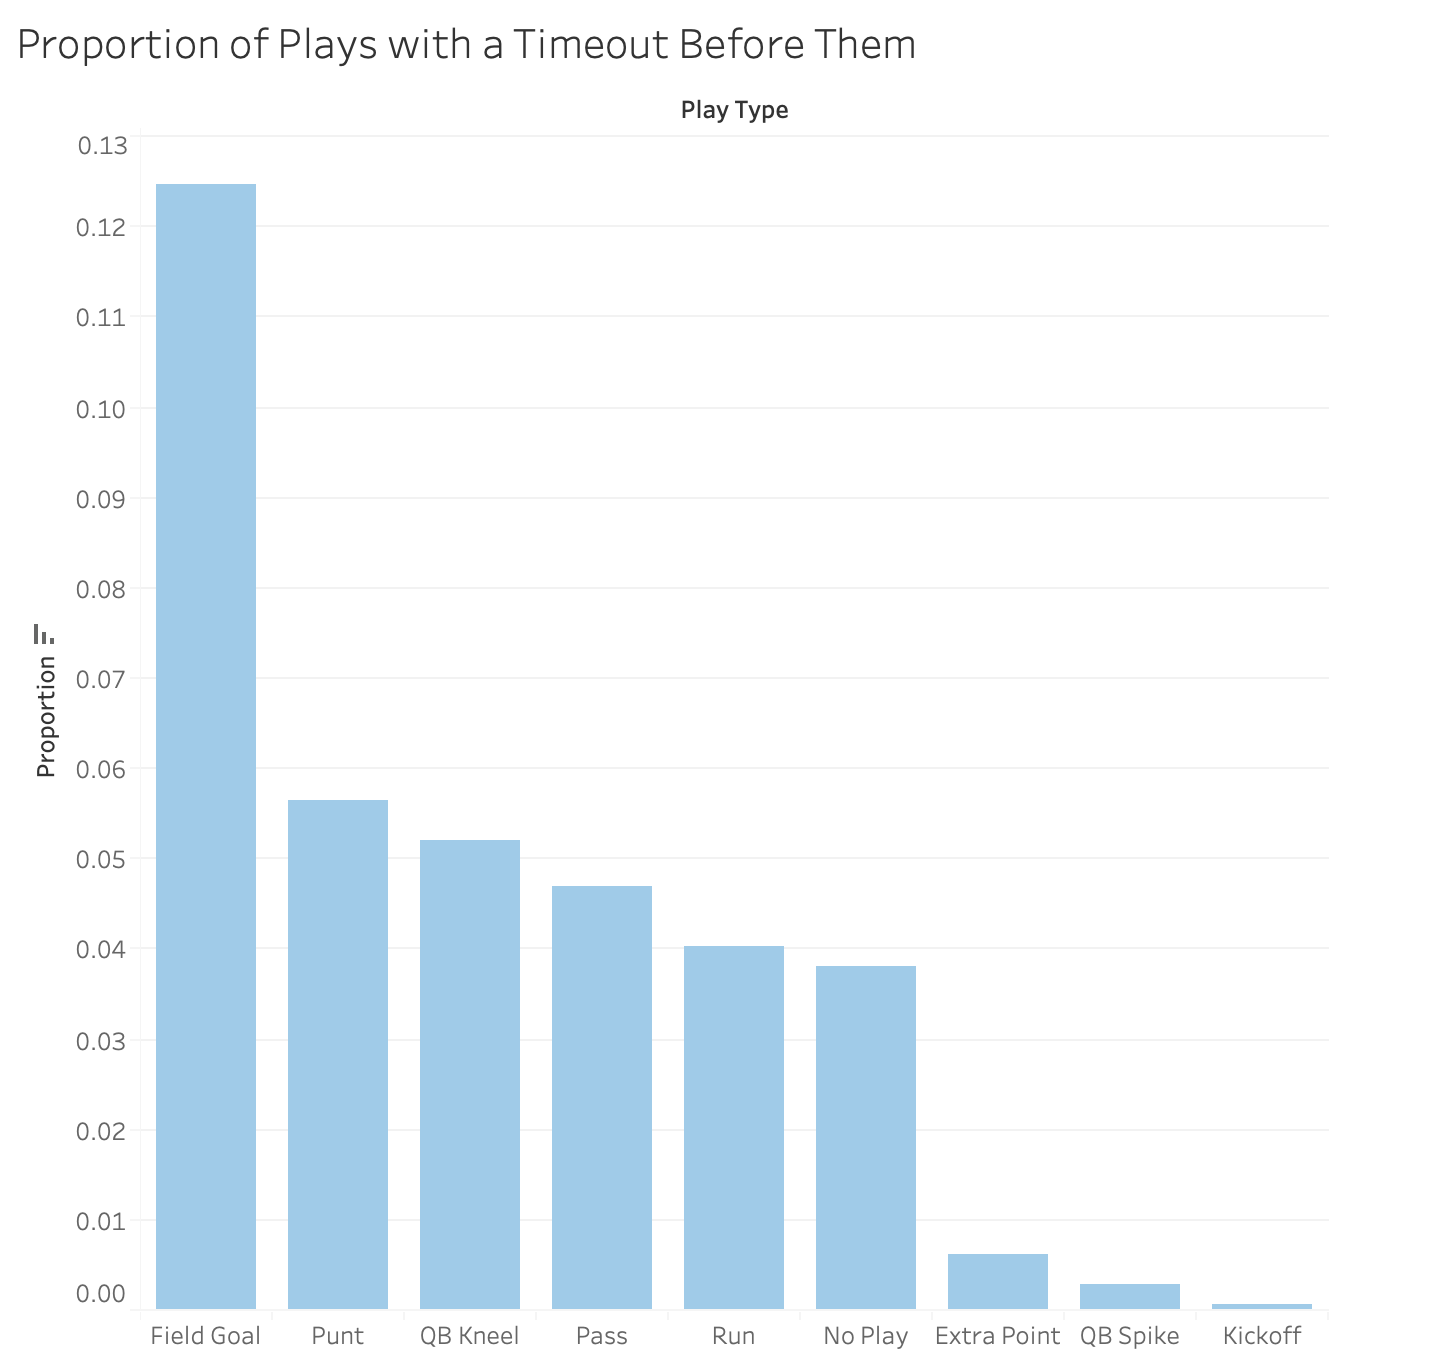

In [6]:
#Proportion of plays with timeout before it
timeout_before_plays = df[(df['timeout'] == 1).shift(1).fillna(False)]
timeout_before_plays_props = (timeout_before_plays['play_type'].value_counts() / df.play_type.value_counts()).sort_values(ascending=False)
timeout_before_plays_props.to_csv('exportedForTableau/timeouts_before_plays.csv')
Image(filename='images/TimeoutProps.png')

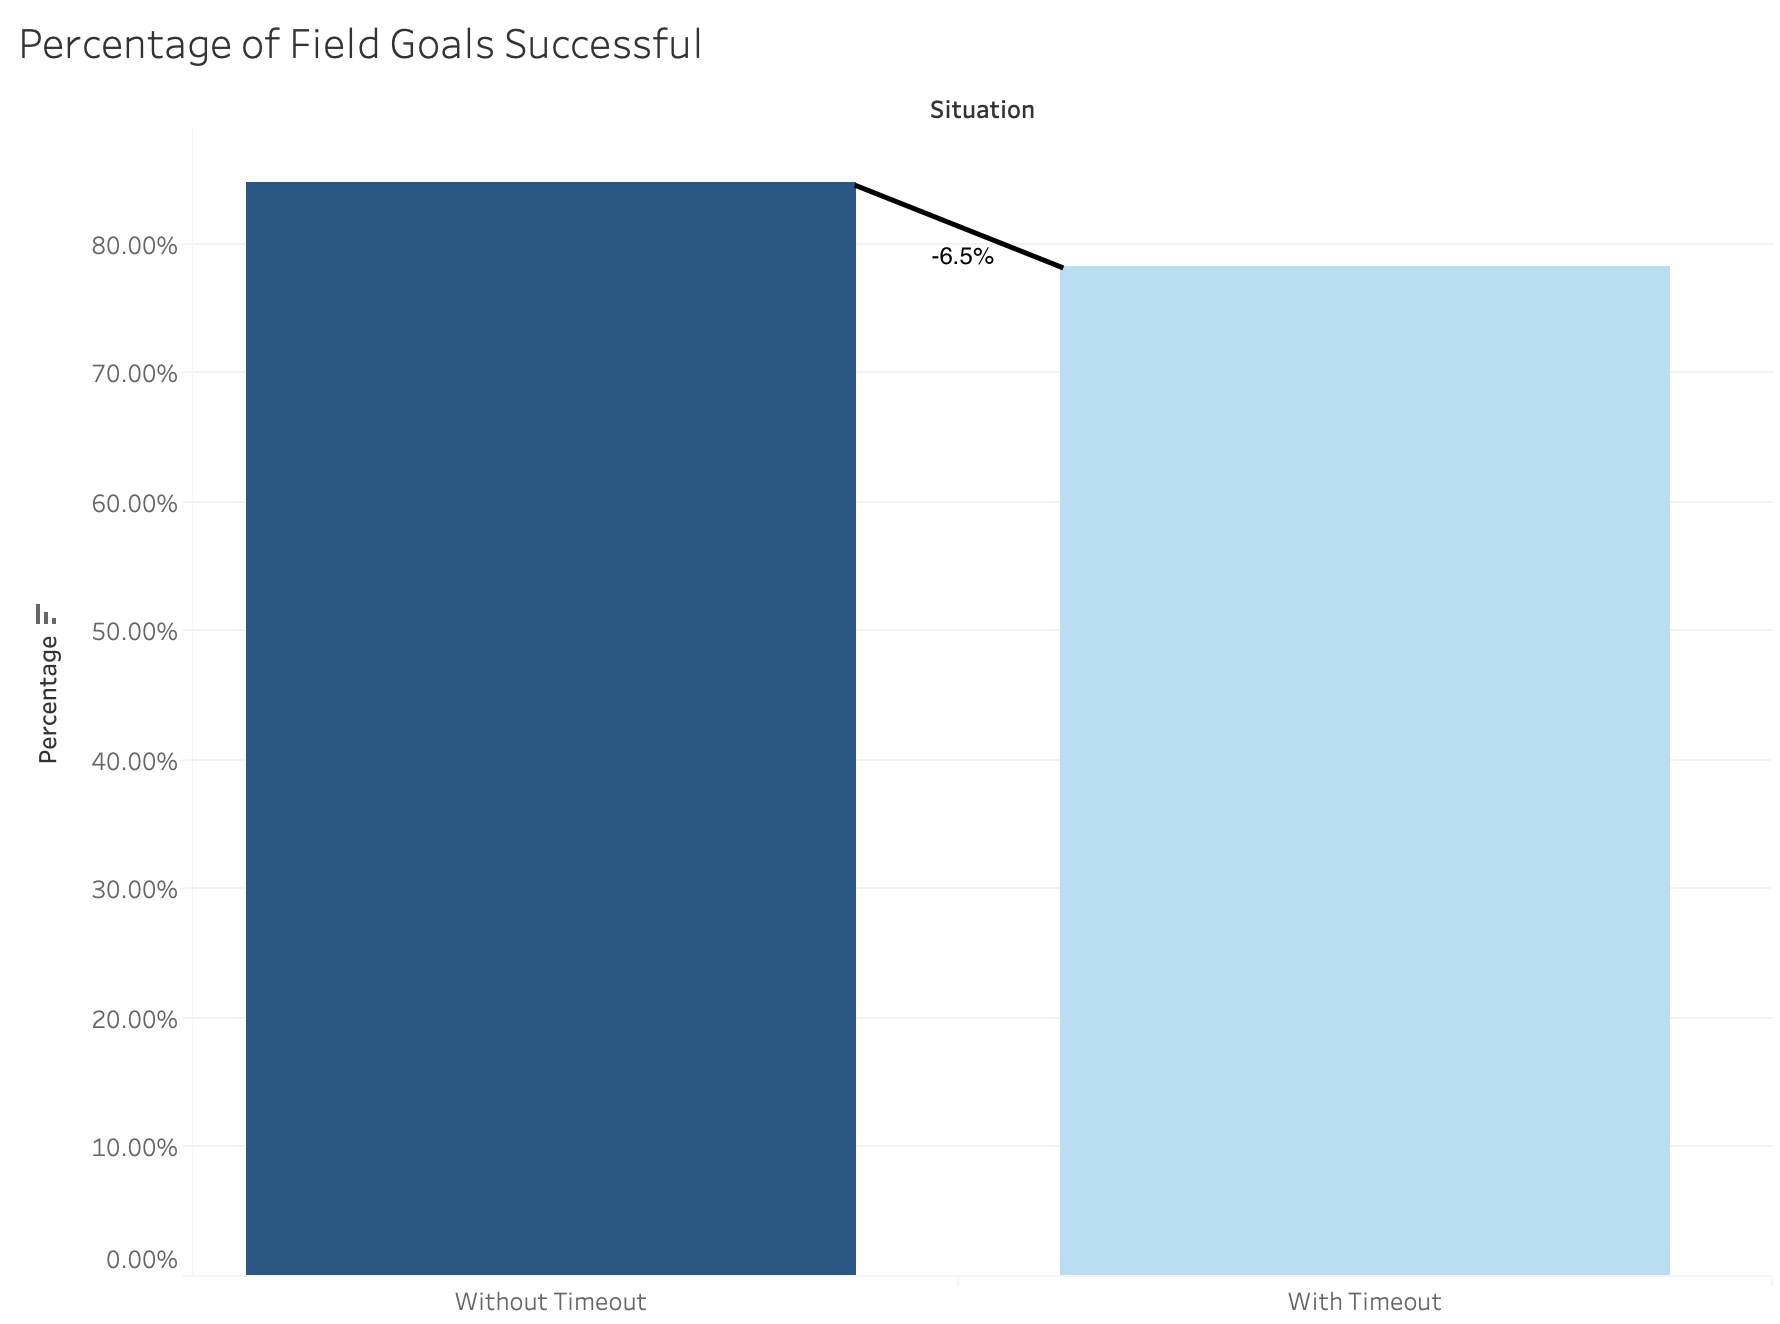

In [7]:
#Proportion of succesful field goals with a timeout before and without
kicks_after_timeout = plays_after_timeout[plays_after_timeout['play_type'] == 'field_goal']
plays_without_timeout = df[(df['timeout'] == 0).shift(1).fillna(False)]
kicks_without_timeout = plays_without_timeout[plays_without_timeout['play_type'] == 'field_goal']

prop_made_without_timeout = kicks_without_timeout[kicks_without_timeout['field_goal_result'] == 'made'].shape[0]/kicks_without_timeout.shape[0]
prop_made_after_timeout = kicks_after_timeout[kicks_after_timeout['field_goal_result'] == 'made'].shape[0]/kicks_after_timeout.shape[0]

x = ['Without Timeout', 'With Timeout']
proportions = [prop_made_without_timeout, prop_made_after_timeout]
x_pos = [i for i, _ in enumerate(x)]

Image(filename='images/Icing.png')

### Results
#### 'Icing' the kicker actually works! There is a roughly 6.5% decrease in successful field goals when a timeout is called just before they kick. Wow! 

## **Question 2)**
### Which teams have scored the most points over the last 9 years? Does that match with the teams with the highest fanbases? Or, can a team not need to score many points to have a large fanbase?

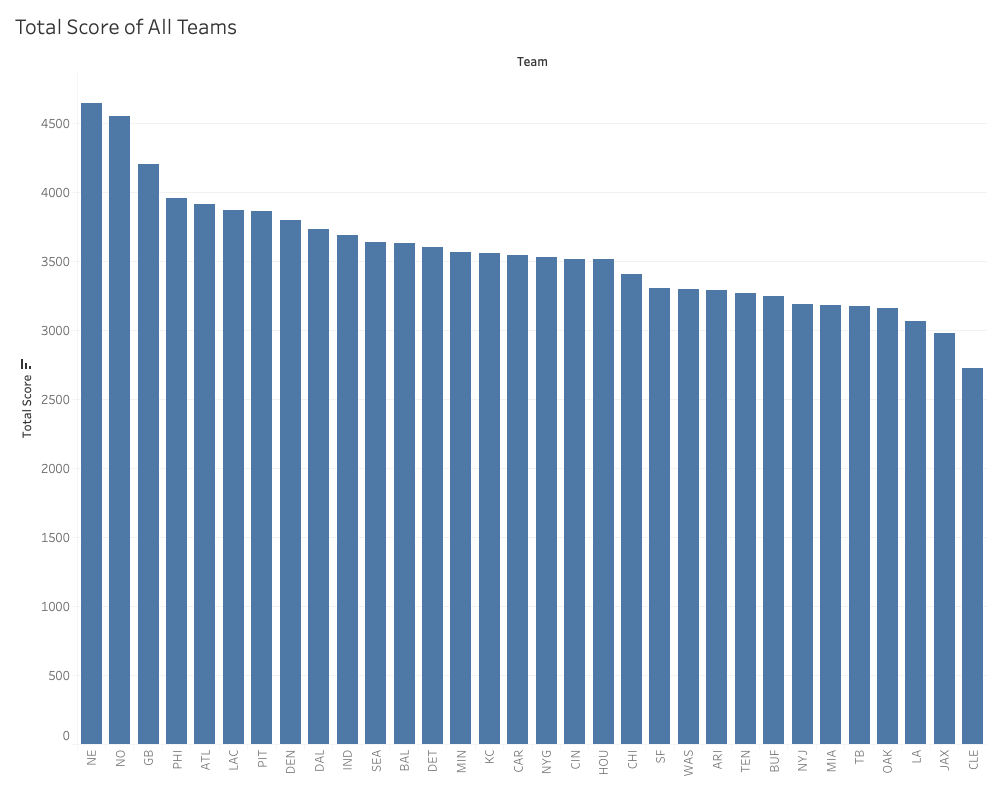

In [8]:
posteam_total_score = df.groupby(['posteam']).score_dif_posteam.sum()
defteam_total_score = df.groupby(['defteam']).score_dif_defteam.sum()

team_total_score = pd.merge(posteam_total_score, defteam_total_score, left_index = True, right_index =True)
team_total_score['total_score'] = team_total_score['score_dif_posteam'] + team_total_score['score_dif_defteam']
team_total_score = team_total_score['total_score']

team_score_sort = team_total_score.sort_values(ascending=False)
team_score_sort.to_csv('exportedForTableau/team_total_score.csv')
Image(filename='images/TotalScoreTeams.png')

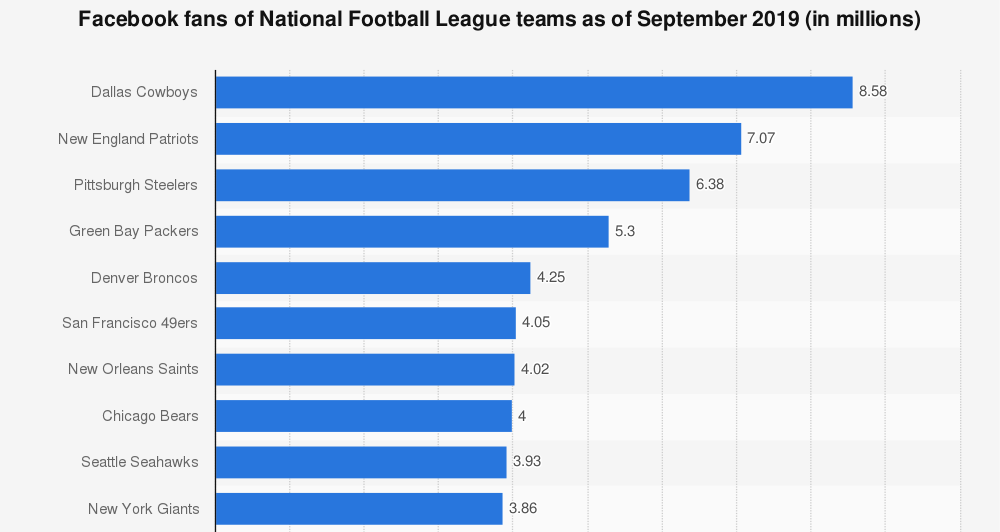

In [15]:
#Graph of Facebook Fans for Each Team
Image(filename='images/FbFans.png')

*Link: https://www.statista.com/statistics/240028/facebook-fans-of-national-football-league-teams/

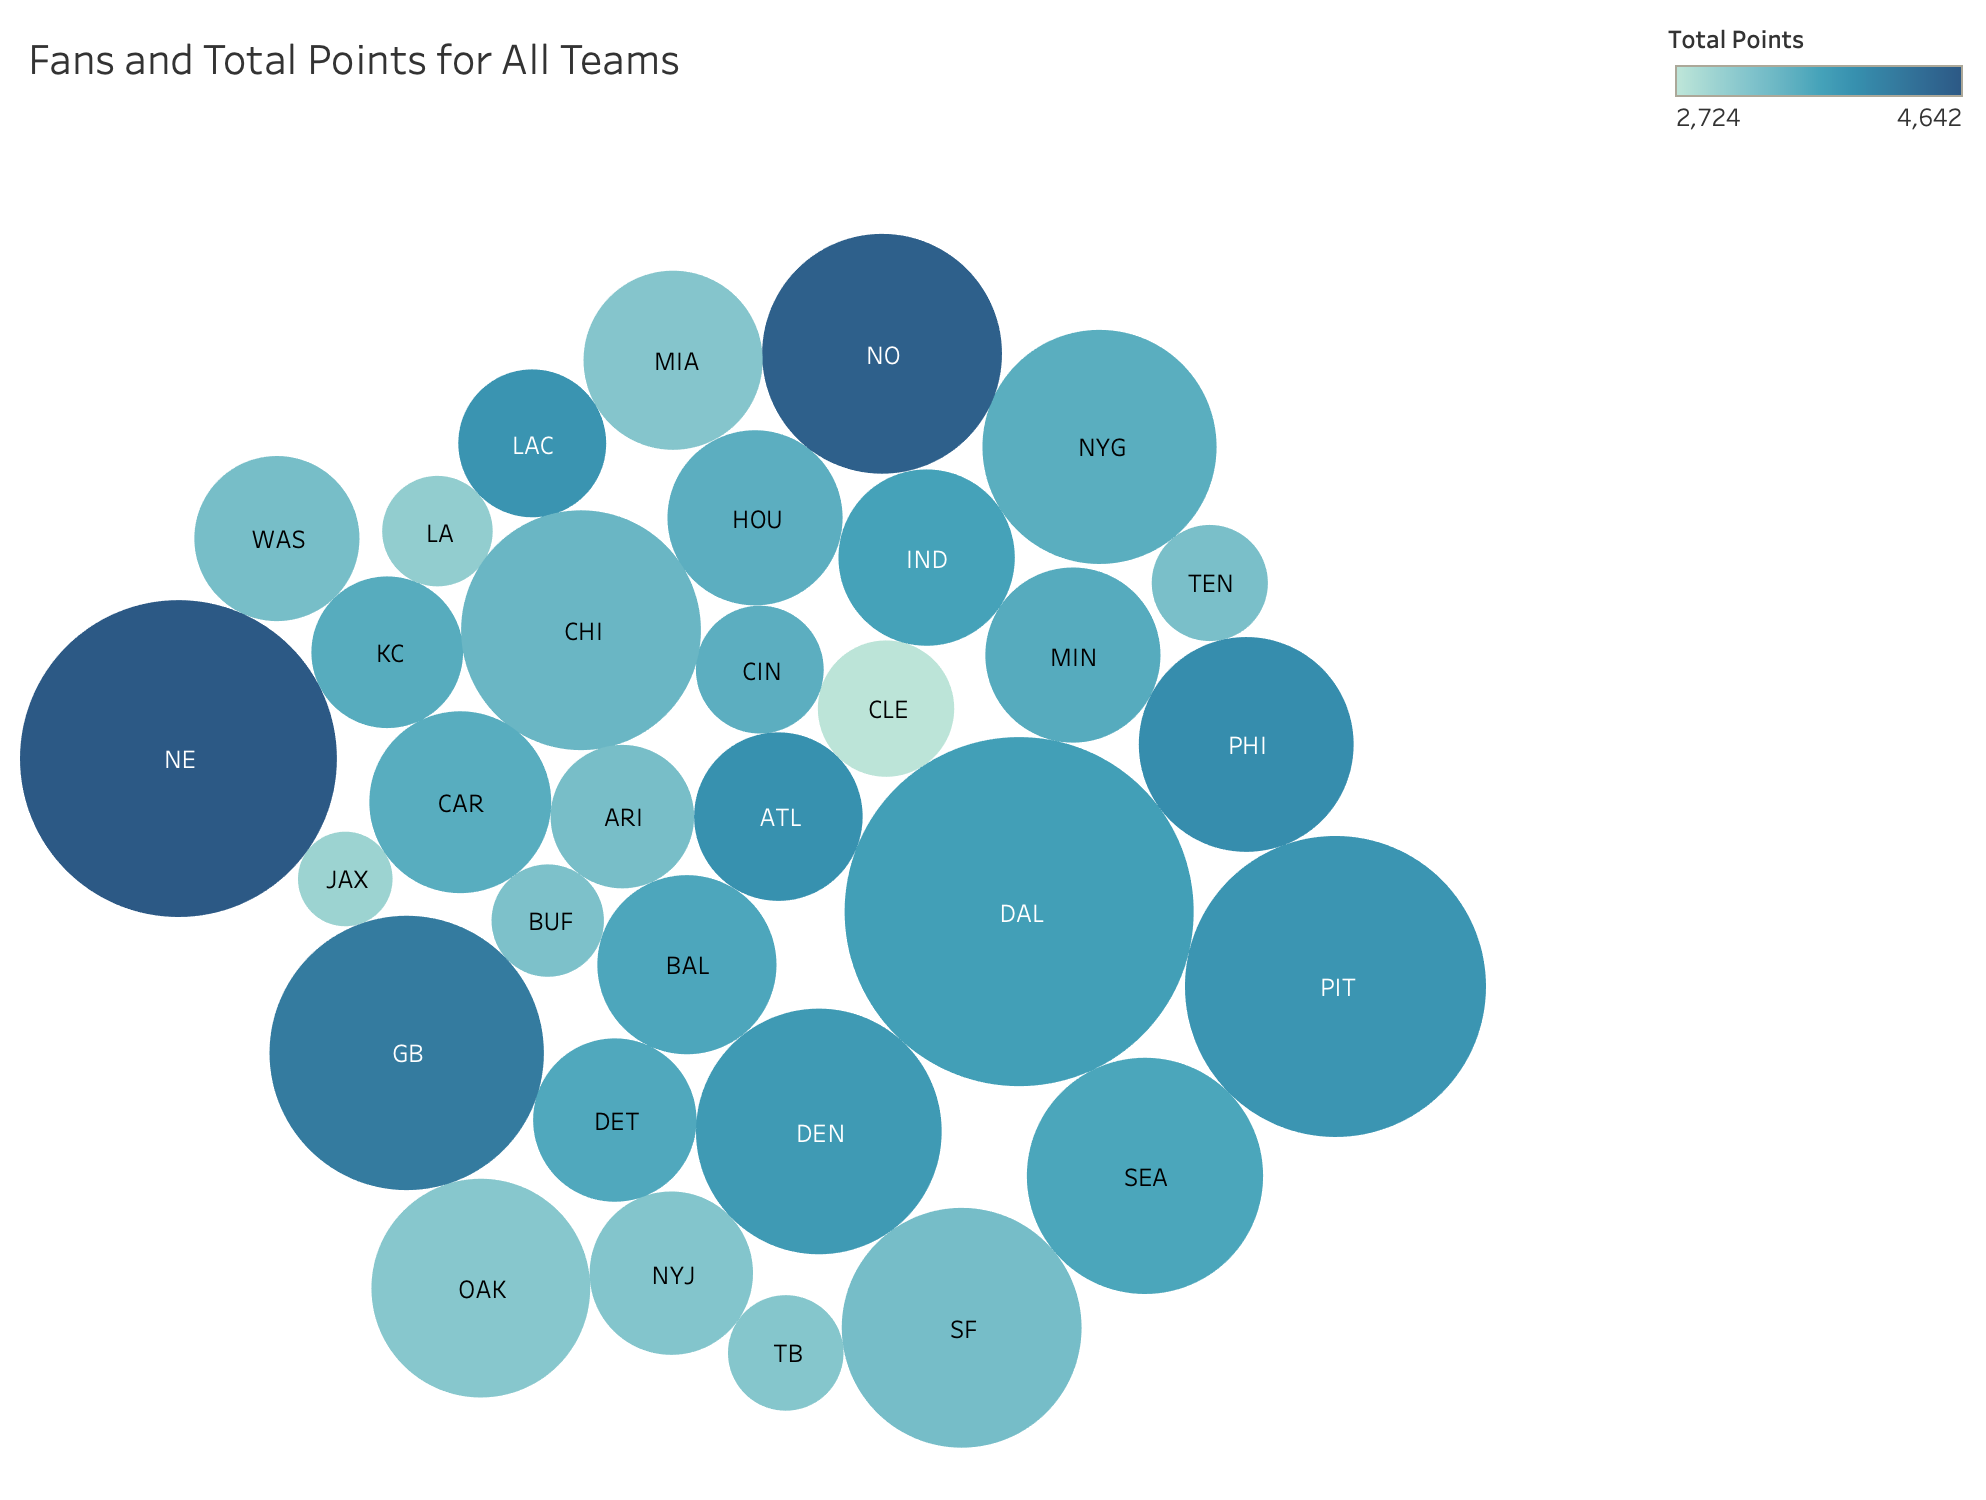

In [11]:
fb_df['fans'] = fb_df['Fans (Millions)']
fb_score_df = pd.merge(team_total_score.sort_values(ascending=False), fb_df, left_index=True, right_index=True)
fb_score_df.to_csv('exportedForTableau/fb_scores.csv')
Image(filename='images/FbAndScore.pg')

### **Based on number of Facebook fans in 2019, the four largest fan bases are:\***
#### 1) Cowboys (9th highest scorer)
#### 2) Patriots (1st highest scorer)
#### 3) Steelers (7th highest scorer)
#### 4) Packers (3rd highest scorer)
#### 5) Broncos (8th highest scorer)

These teams are all found within the top nine scoring teams. 
So there is some overlap, but not as much as expected. The other high scoring teams - the Eagles, Saints, and Falcons - are scattered throughout the top twenty fanbases.

<a id='q3'></a>
## **Question 3)**
### Did the 2013 Denver Broncos really deserve to lose the Super Bowl?





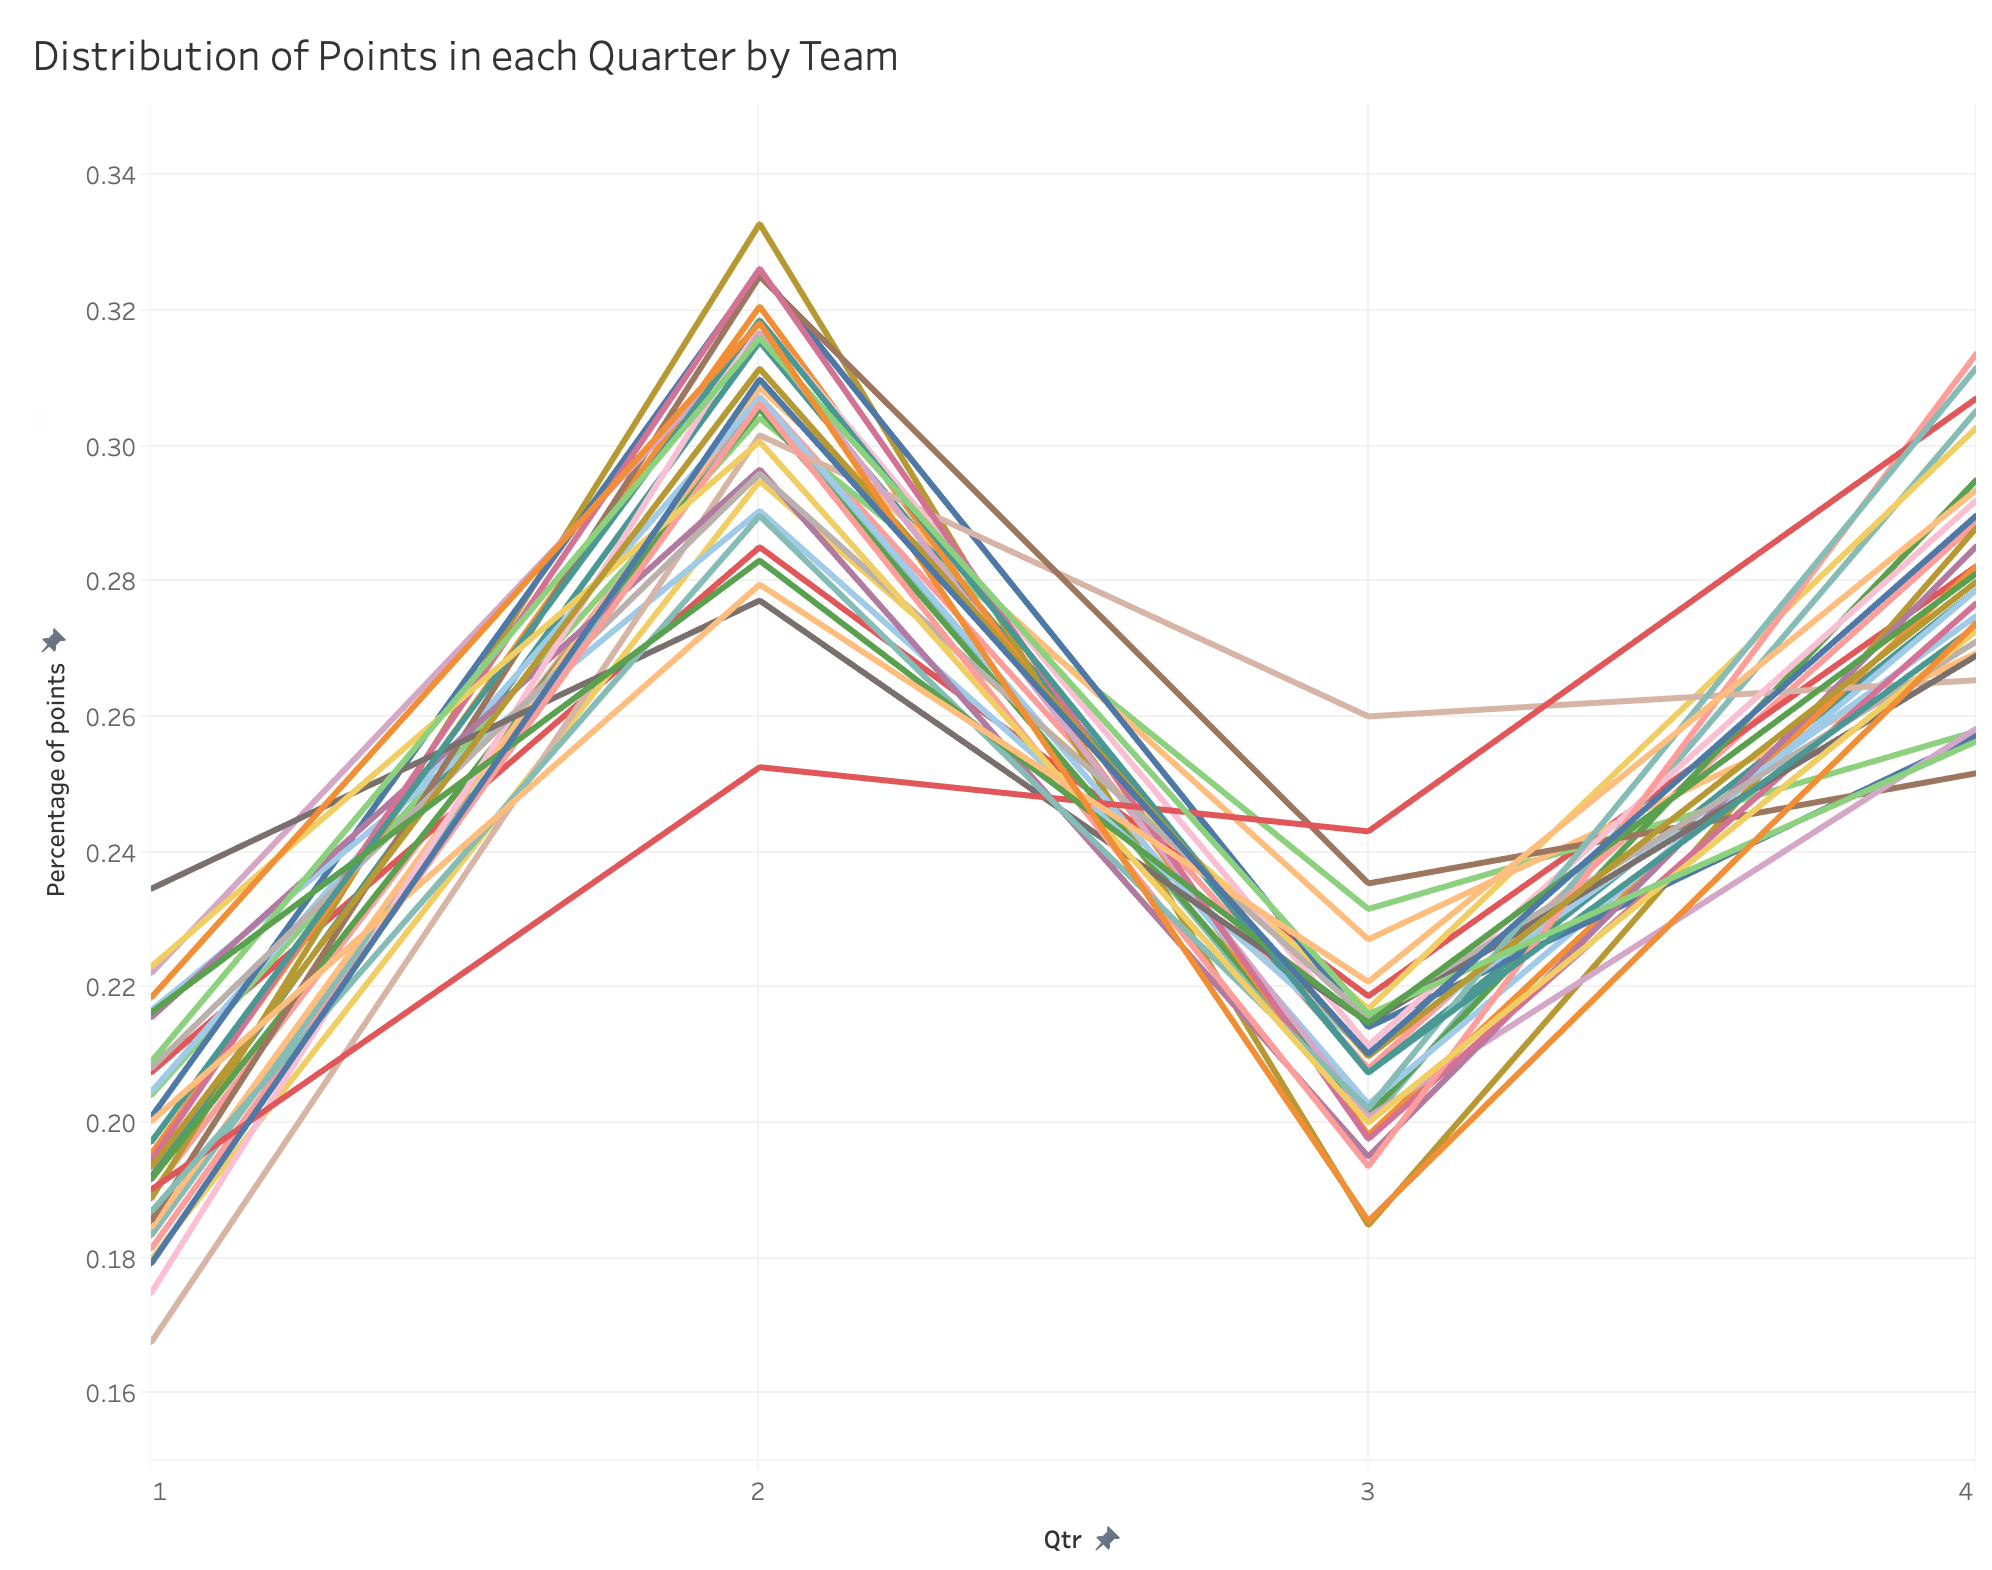

In [11]:
posteam_qtr_score = df.groupby(by=['qtr', 'posteam']).score_dif_posteam.sum()
defteam_qtr_score = df.groupby(by=['qtr', 'defteam']).score_dif_defteam.sum()
team_qtr_score = pd.merge(posteam_qtr_score, defteam_qtr_score, left_index=True, right_on=['qtr', 'defteam'])
team_qtr_score = team_qtr_score['score_dif_posteam'] + team_qtr_score['score_dif_defteam']
team_qtr_score = team_qtr_score.unstack(level=0)
team_qtr_score['sum'] = team_qtr_score.sum(axis = 1)
team_qtr_prop = team_qtr_score.div(team_qtr_score["sum"], axis=0)
team_qtrs_props = team_qtr_prop[[1, 2, 3, 4]].T
team_qtrs_props.to_csv('exportedForTableau/team_pts_qtr.csv')
Image(filename='images/PointsByQuarter.png')

From this graph, we can see that the majority of teams score the largest proportion of their points over all 9 seasons in the 2nd and 4th quarters, with a few outliers. However, can we see anything different if we break it up by quarter and season?

In [9]:
imgs = {1: '1stQuarter.png', 2: '2ndQuarter.png', 3: '3rdQuarter.png', 4: '4thQuarter.png'}

def pts_by_qtr(df1, qtr):
    my_df = df1[df1['qtr'] == qtr]
    posteam_qtr_score = my_df.groupby(by=['season', 'posteam']).score_dif_posteam.sum()
    defteam_qtr_score = my_df.groupby(by=['season', 'defteam']).score_dif_defteam.sum()
    team_qtr_score = pd.merge(posteam_qtr_score, defteam_qtr_score, left_index=True, right_on=['season', 'defteam'])
    team_qtr_score = team_qtr_score['score_dif_posteam'] + team_qtr_score['score_dif_defteam']
    team_qtr_score = team_qtr_score.unstack(level=0)
    team_qtr_score.head()
    team_qtr_score_yr = team_qtr_score[[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]].T
    team_qtr_score_yr.to_csv('exportedForTableau/year_pts_qtr_' + str(qtr) + '.csv')
    Image(filename=imgs[qtr])

pts_by_qtr(df, 1)
pts_by_qtr(df, 2)
pts_by_qtr(df, 3)
pts_by_qtr(df, 4)



NameError: name 'df' is not defined

This view is also a bit jumbled, as it seems that the performance of every team in all quarters varies greatly by season. But if we look at the Denver Broncos by themselves, it gets really interesting...

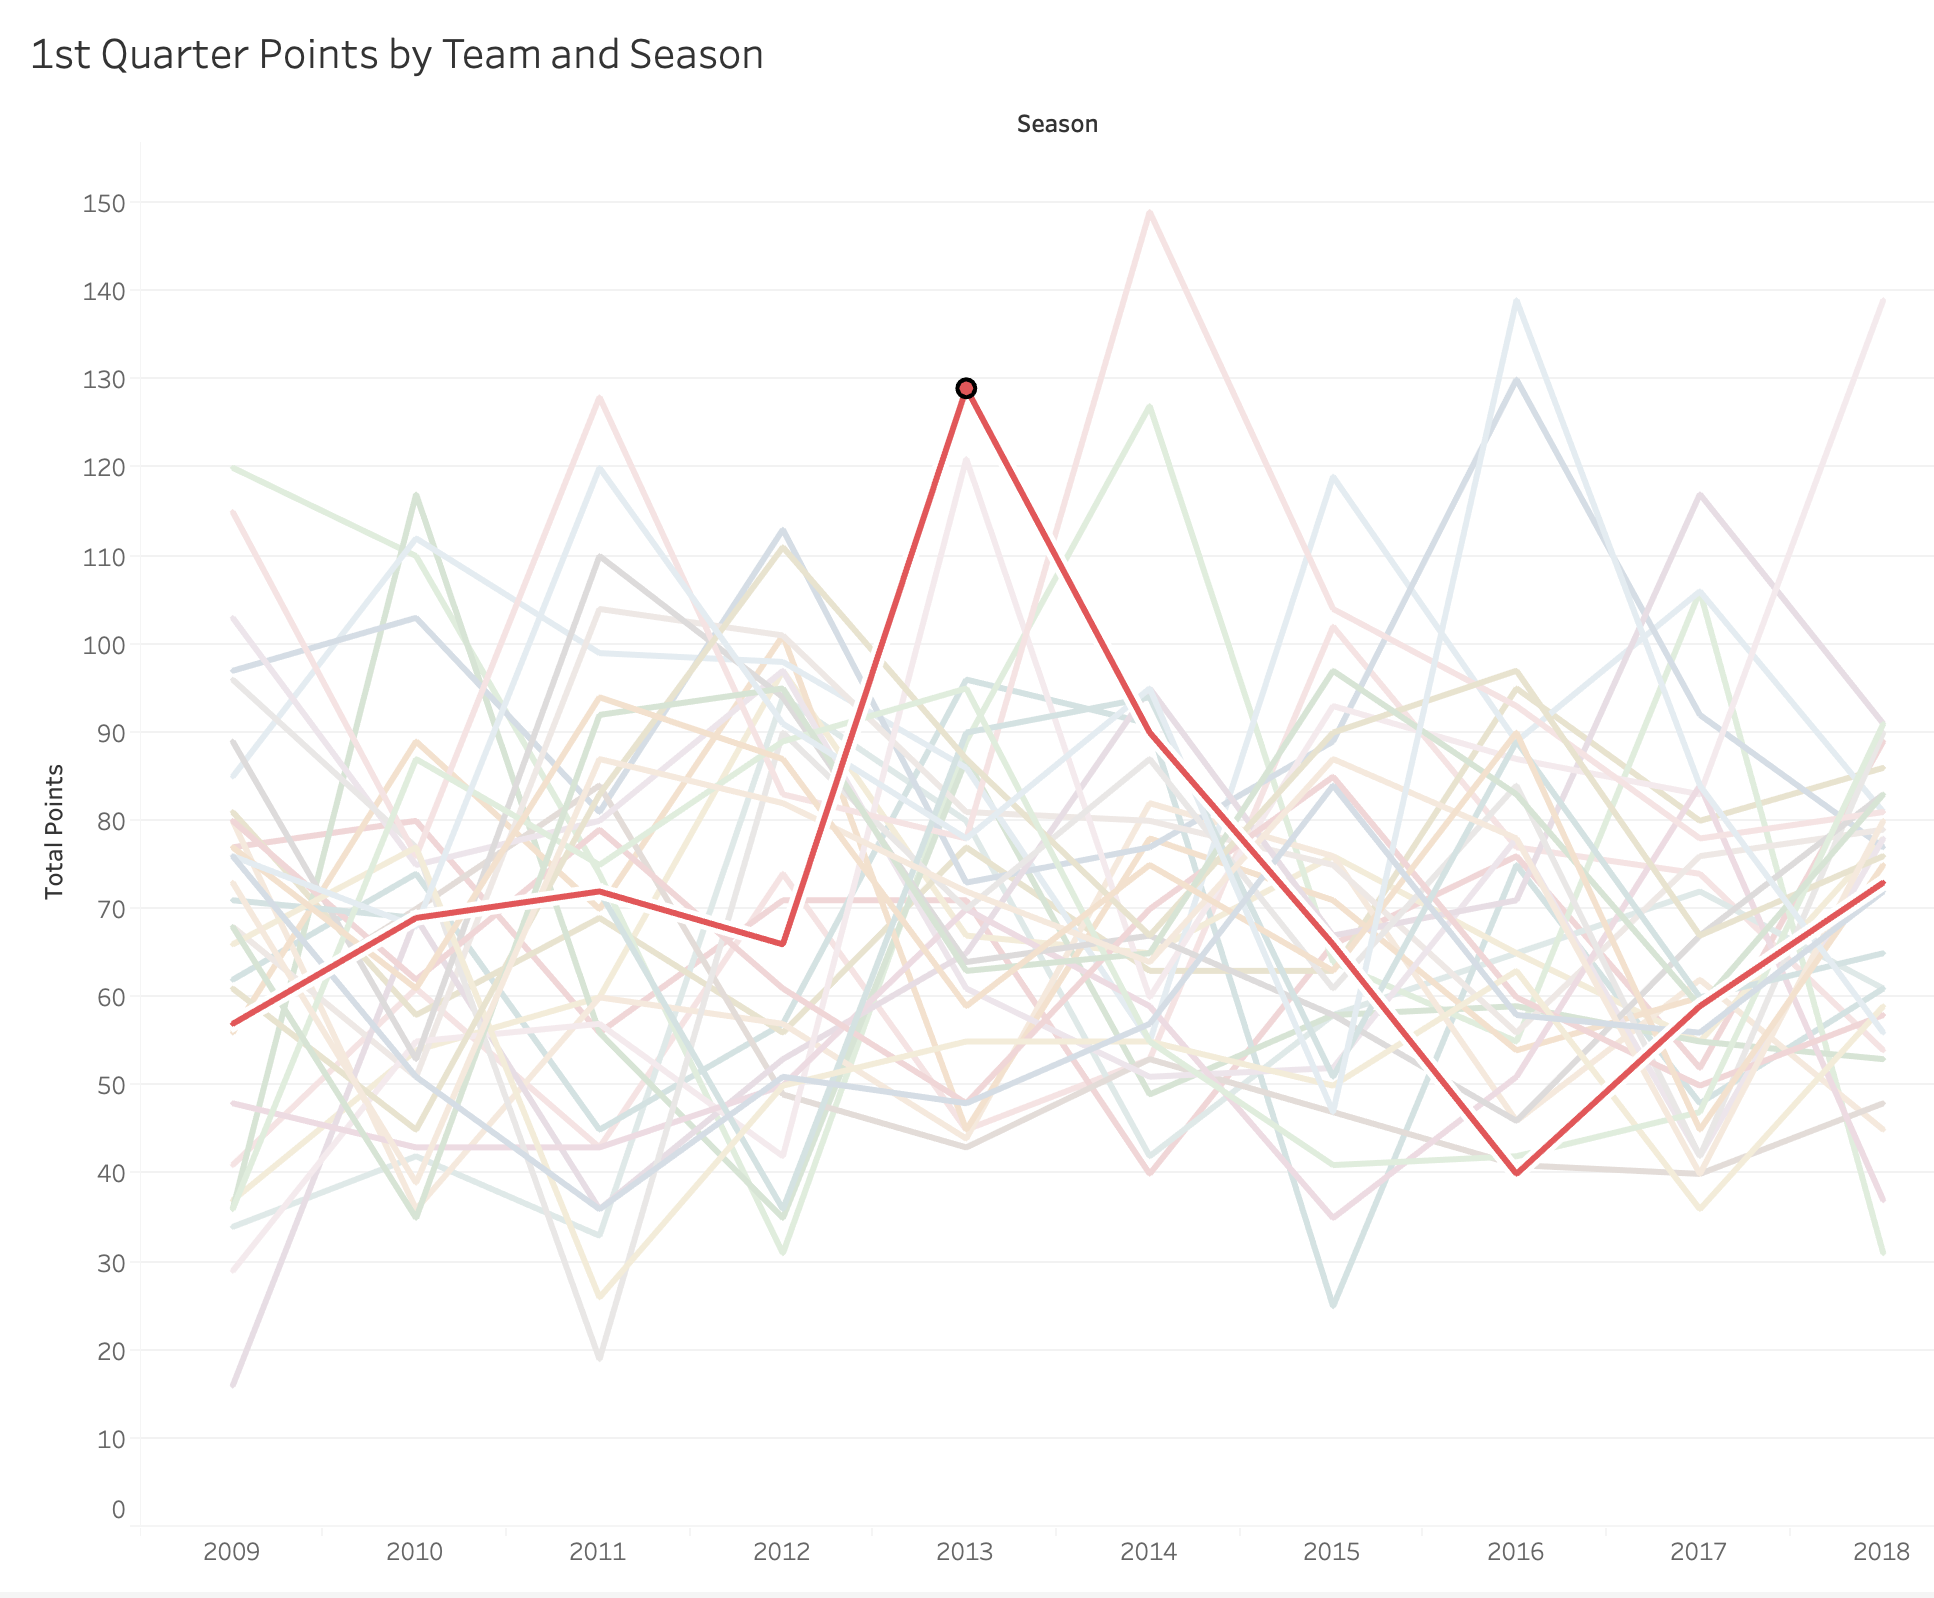

In [12]:
Image(filename='images/DEN1st.png')

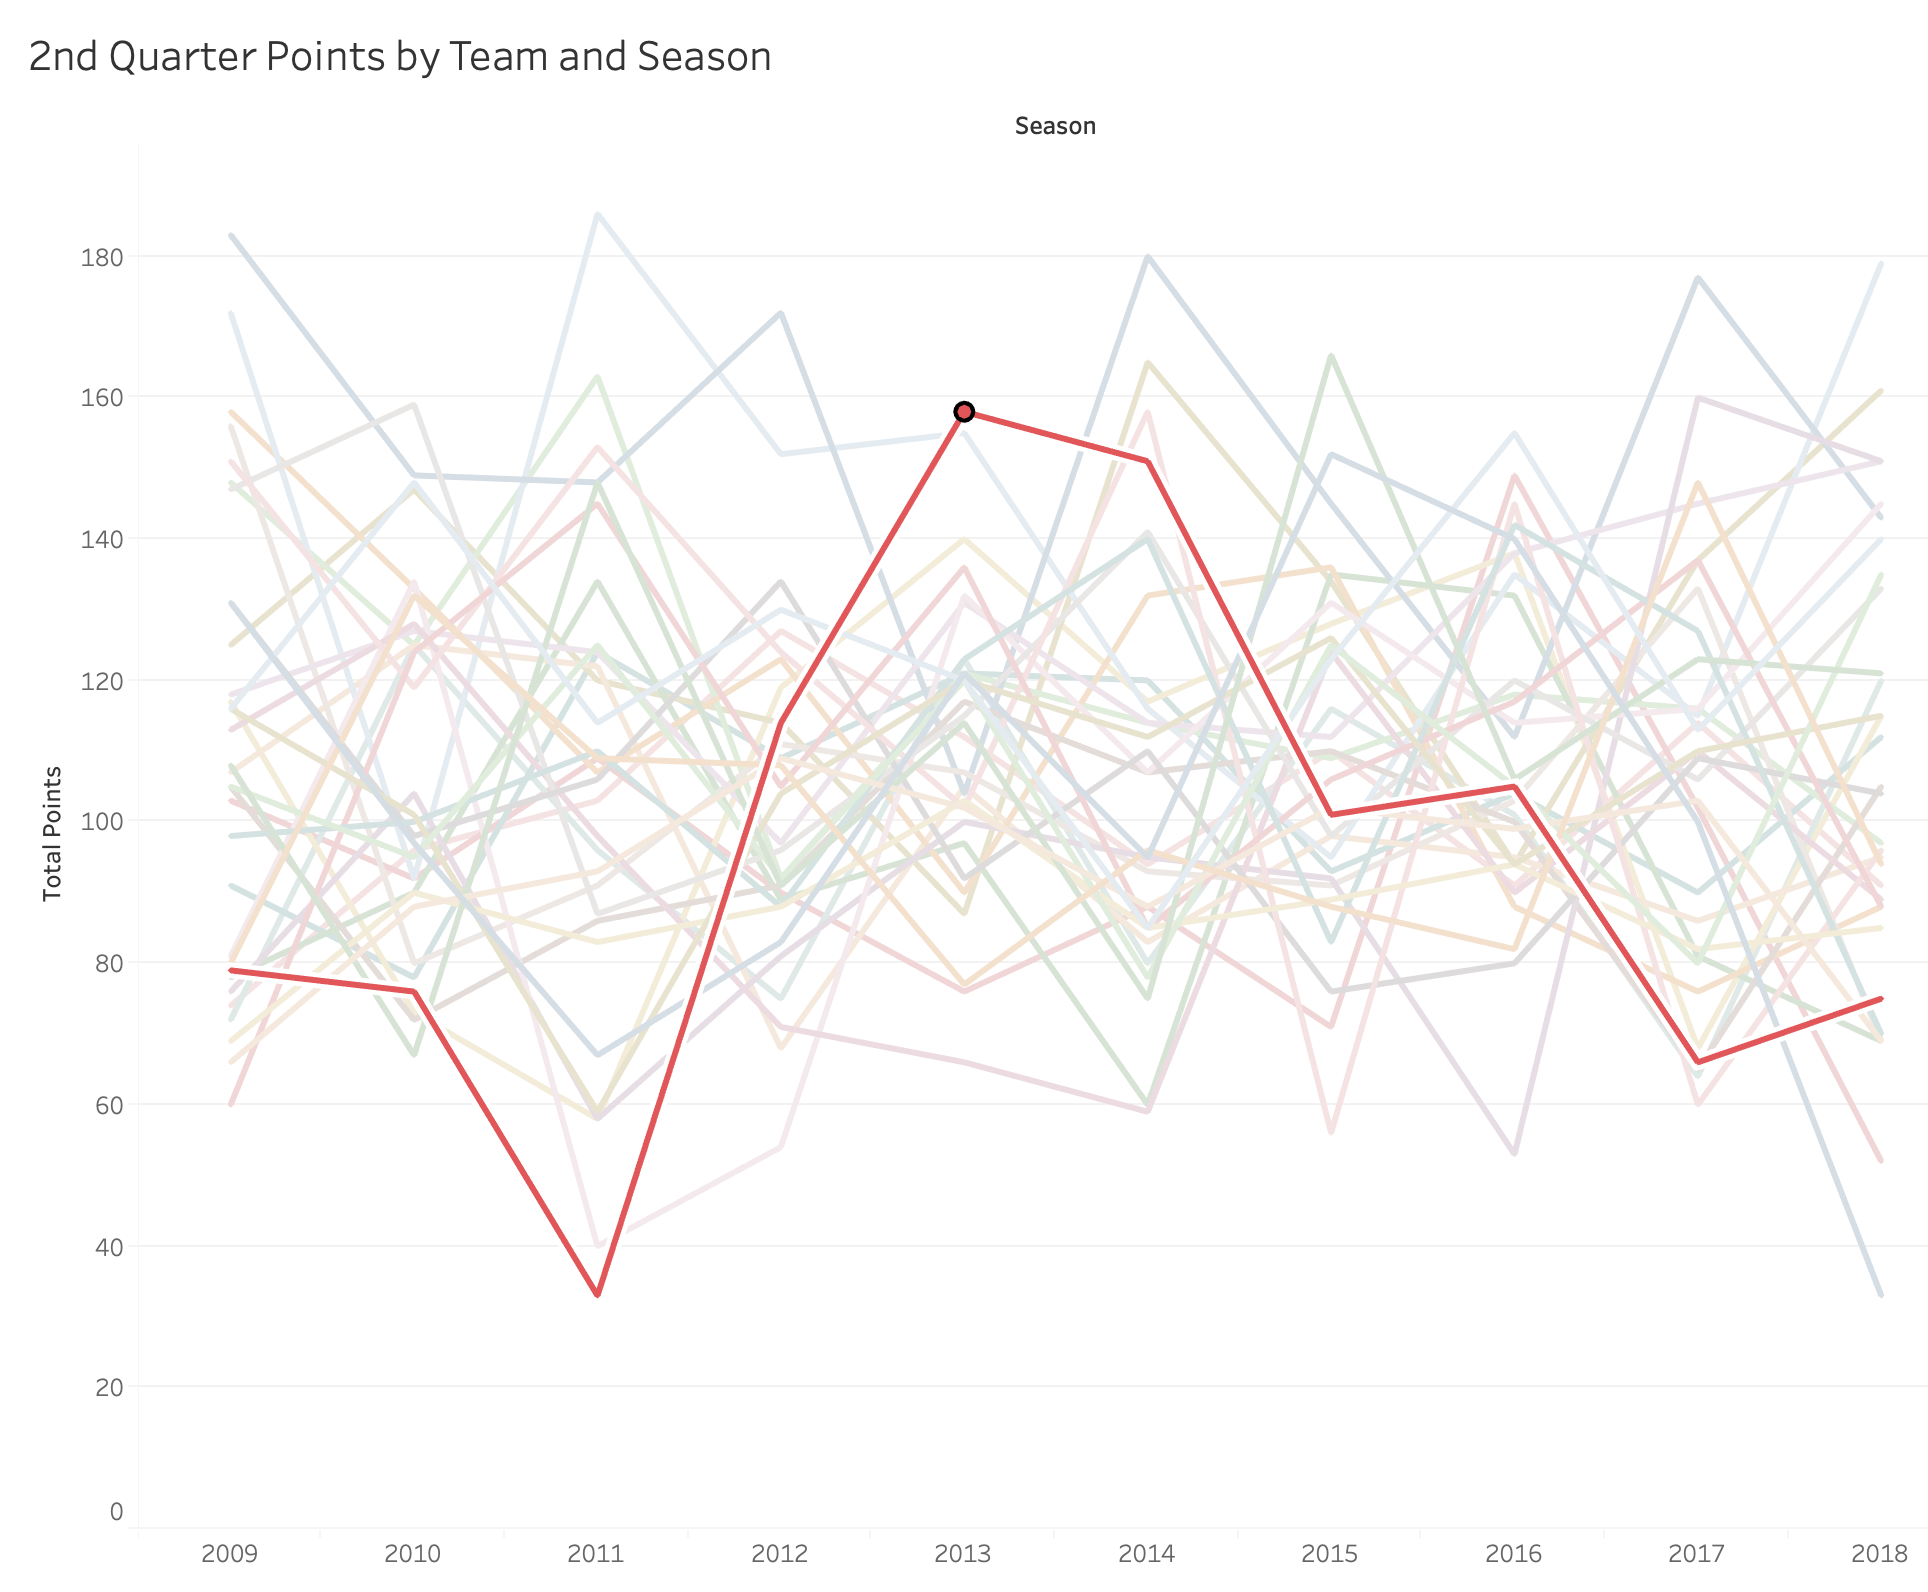

In [14]:
Image(filename='images/DEN2nd.png')

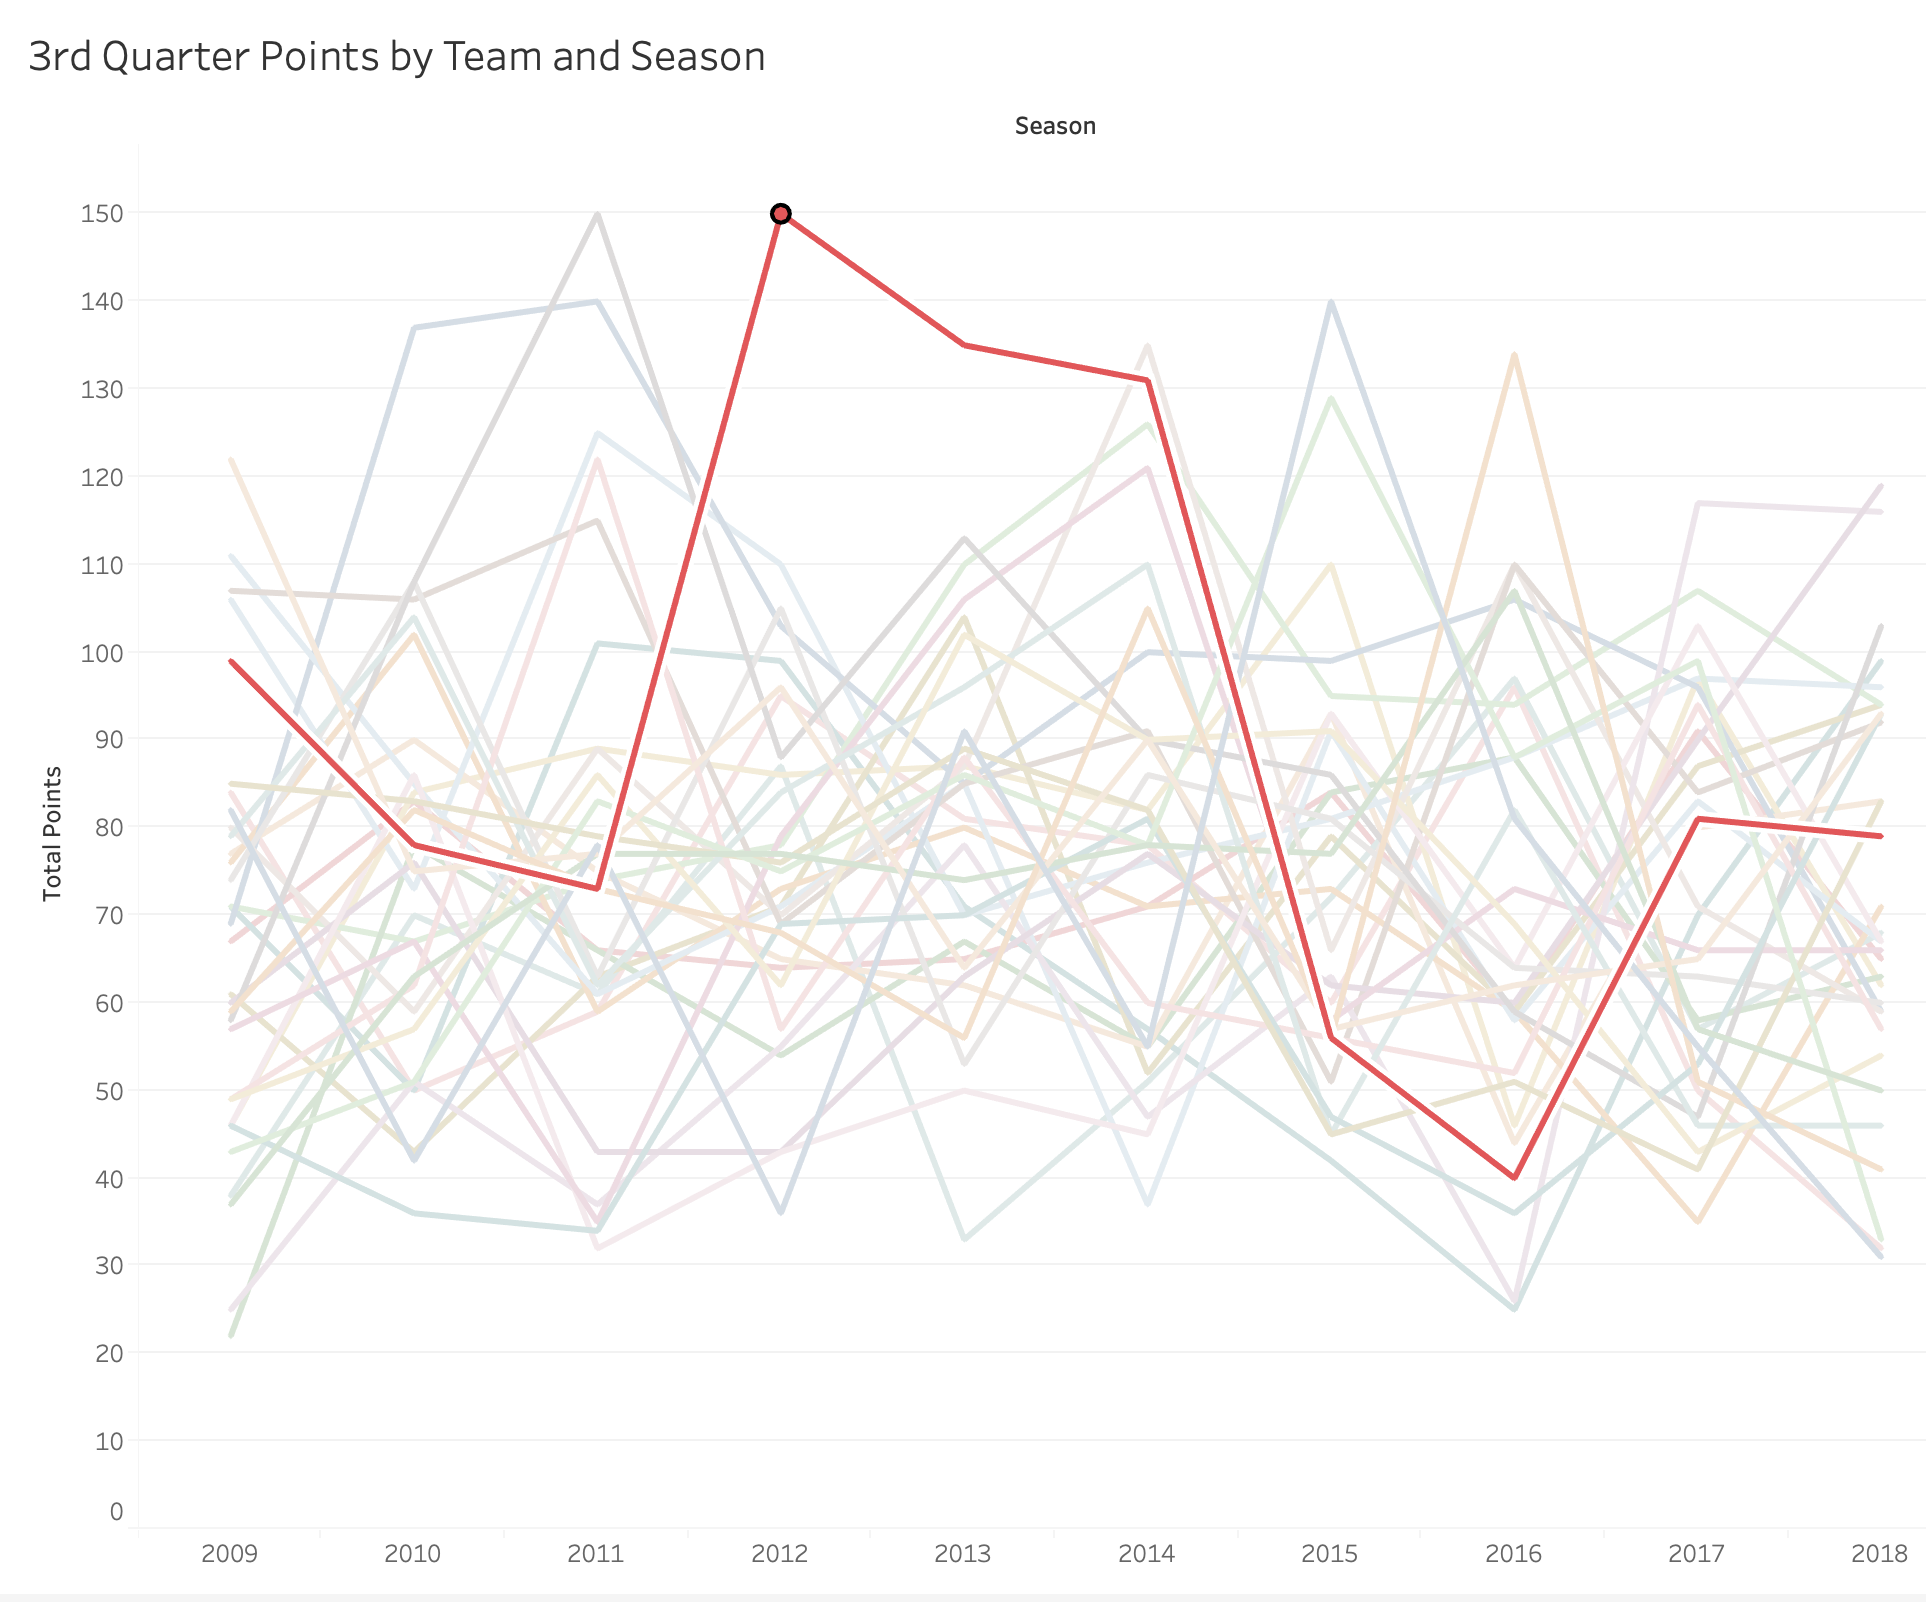

In [15]:
Image(filename='images/DEN3rd.png')

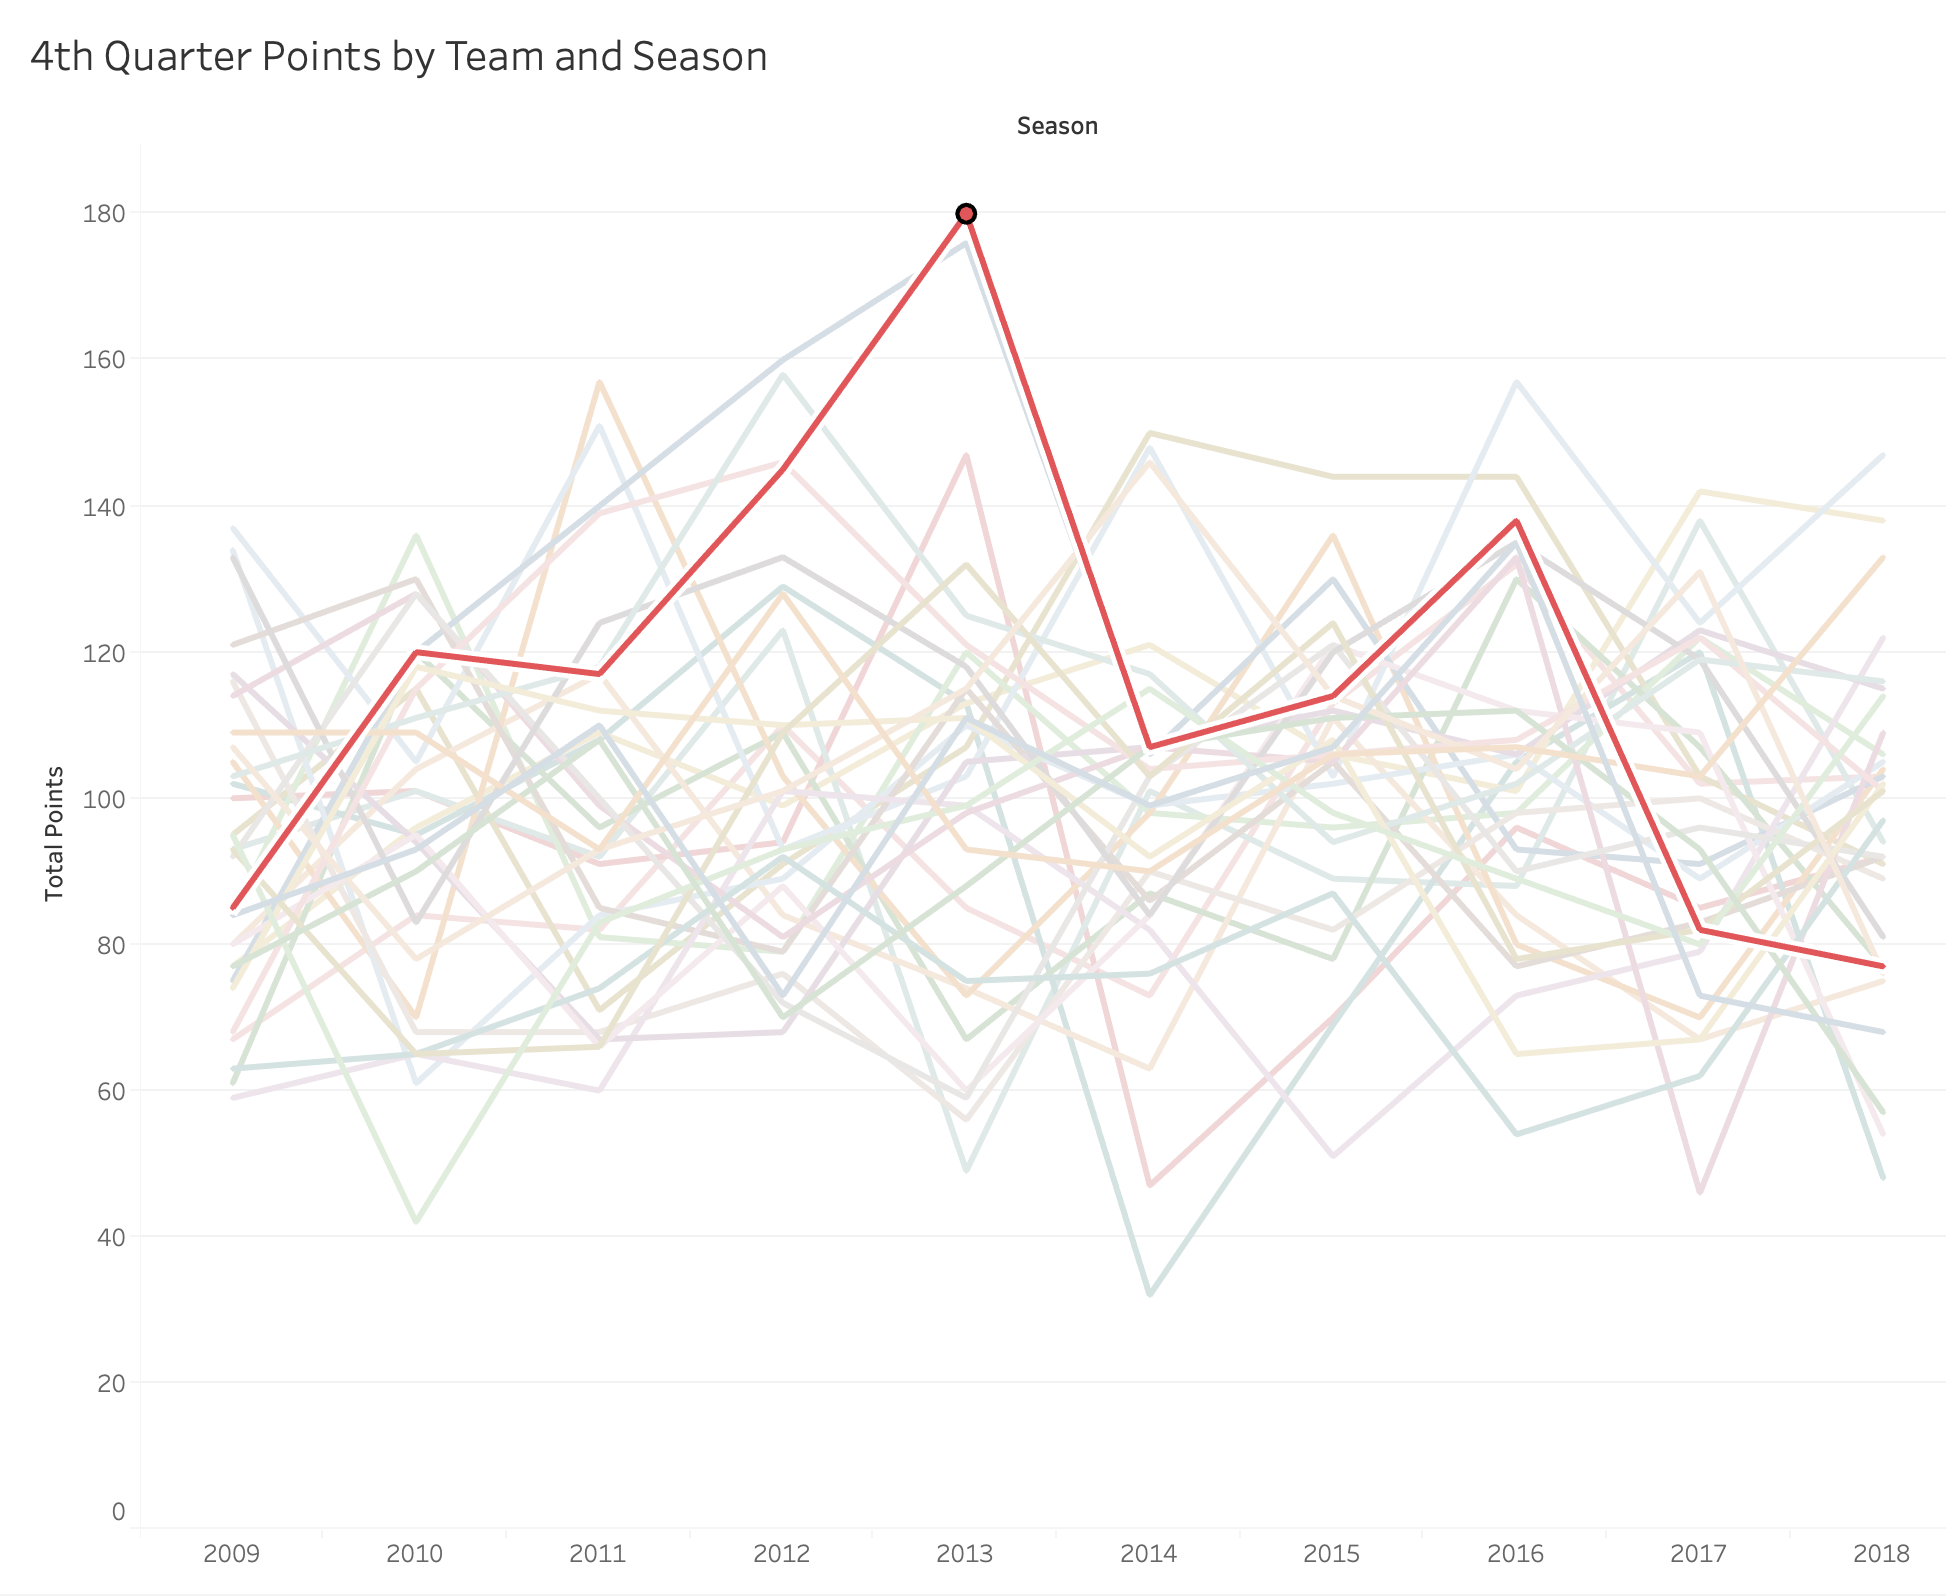

In [13]:
Image(filename='images/DEN4th.png')

In the 2013 season, Denver had all of its highest scoring quarters ever. Also, they were the highest scoring team in the entire NFL for all those quarters as well! A truly historic season. Now, lets stack them against the Seattle Seahawks from that year. 

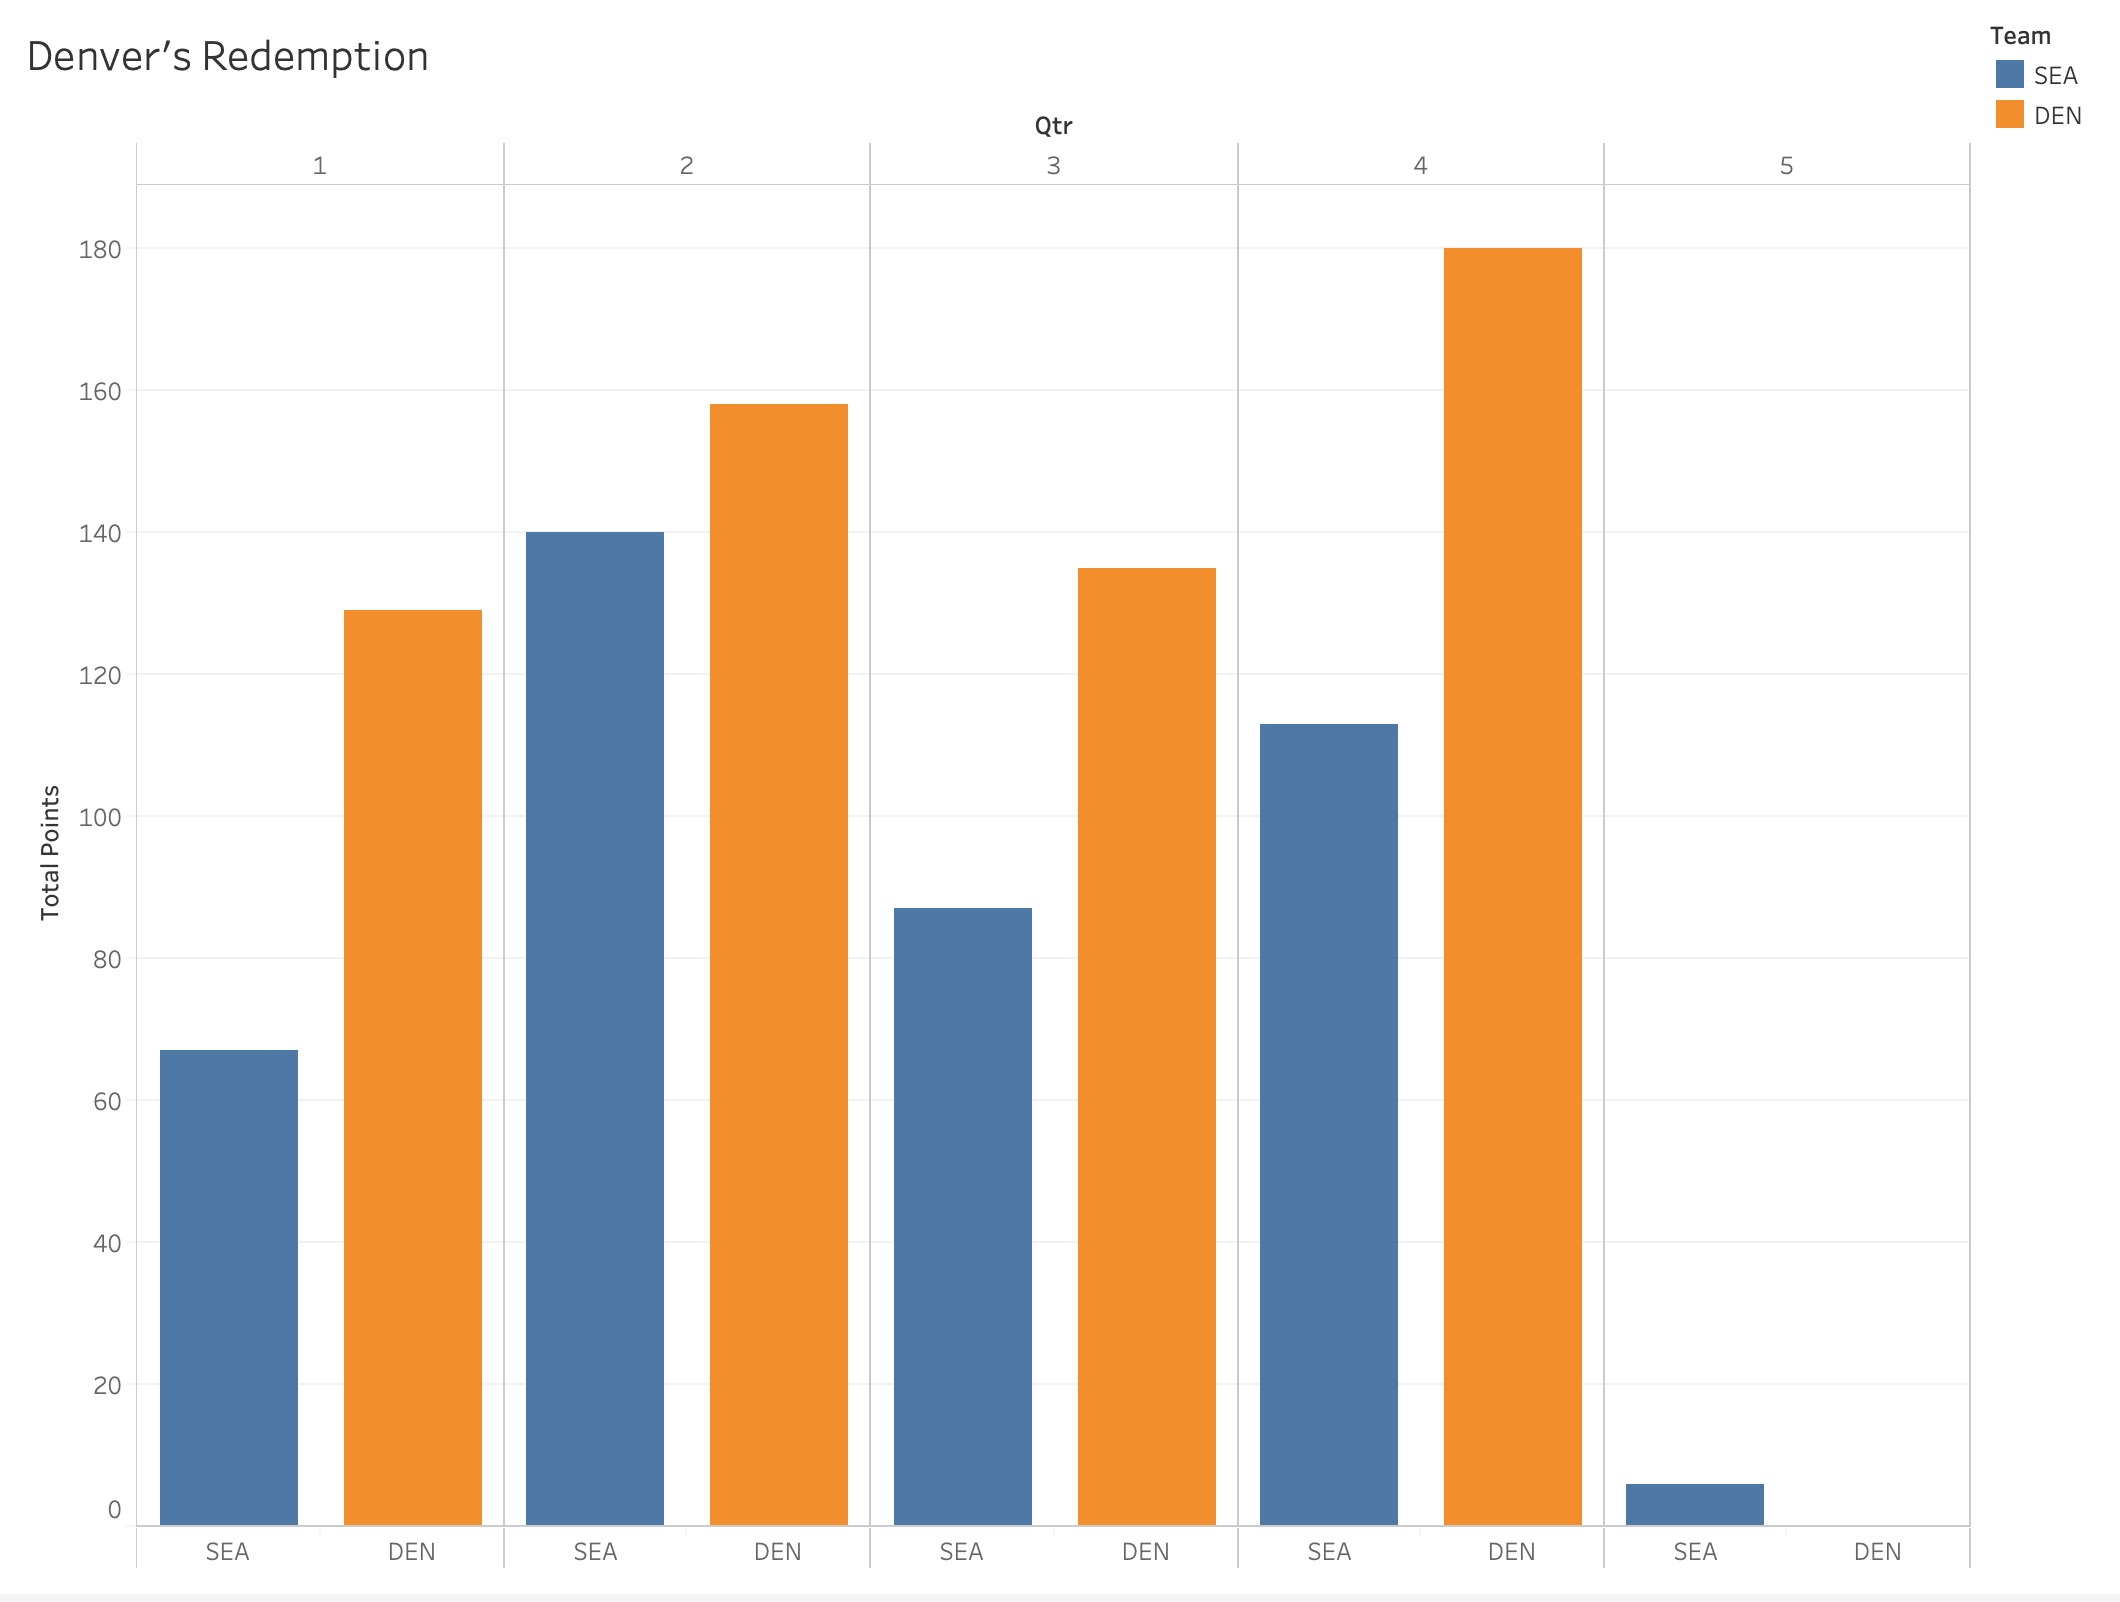

In [16]:
posteam_qtr_score = df.groupby(by=['season', 'qtr', 'posteam']).score_dif_posteam.sum()
defteam_qtr_score = df.groupby(by=['season', 'qtr', 'defteam']).score_dif_defteam.sum()
team_qtr_score = pd.merge(posteam_qtr_score, defteam_qtr_score, left_index=True, right_on=['season', 'qtr', 'defteam'])
team_qtr_score = team_qtr_score['score_dif_posteam'] + team_qtr_score['score_dif_defteam']
team_qtr_score = team_qtr_score.unstack(level=0)
den_vs_sea = team_qtr_score[2013].unstack(level=0).T[['DEN', 'SEA']]
den_vs_sea.to_csv('exportedForTableau/den_sea.csv')
Image(filename='images/DENvsSEA.png')

Although the Broncos eventually lost the superbowl to the Seahawks, they outscored them in every single quarter (except OT). Suggesting, they probably deserved to win after all!

# **Findings**

1. Icing does work, although it is only to a certain small extent.

2. An NFL team does not need to score a lot of points to maintain a large fanbase, as can be seen in he case of the Dallas Cowboys. 

3. The 2013 Denver Broncos did not deserve to lose the Super Bowl. They conducted a historic offense during that season, and probably would have won if the game was played again. 